In [52]:
import os 
os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.9.0"

from matplotlib import pyplot as plt

from plio.io.io_gdal import GeoDataset 
import numpy as np

from glob import glob

from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.spatial.isis import point_info
from autocnet.cg import change_detection as cd

from plio.io.io_gdal import GeoDataset
from pysis import isis
from pysis.exceptions import ProcessError

from IPython.display import display

import shutil

from autocnet.utils import hirise 
from autocnet.utils.utils import bytescale

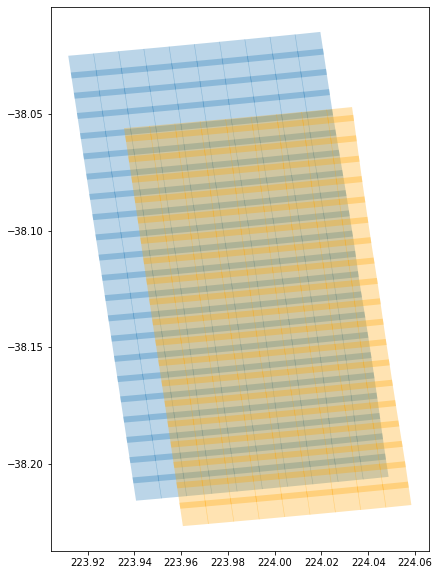

In [3]:
df1 = hirise.load_segments("/scratch/krodriguez/hirise/bolder_shift/ESP_014038_1415")
df2 = hirise.load_segments("/scratch/krodriguez/hirise/bolder_shift/ESP_031022_1415")

ax = df1.plot(figsize=(10,10), alpha=.3)
df2.plot(figsize=(20,50), alpha=.3, ax=ax, color="orange")

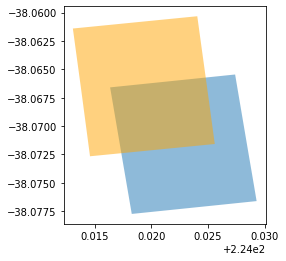

In [4]:
p = Point(224.024, -38.07)

roi1 = df1[df1.intersects(p)].reindex()
roi1_geoms = roi1["footprint"]

roi2 = df2[df2.intersects(roi1.footprint.unary_union)]
roi2 = roi2[roi2.intersects(p)].iloc[0:1]


ax = roi1.plot(alpha=.5)
roi2.plot(ax=ax, alpha=.5, color="orange")

roi1 = roi1.iloc[0]
roi2 = roi2.iloc[0]

In [62]:
new_dir = '/tmp/'

roi1_path = os.path.join(new_dir, os.path.basename(roi1.path))
roi2_path = os.path.join(new_dir, os.path.basename(roi2.path))

shutil.copyfile(roi1.path, new_roi1_path)
shutil.copyfile(roi2.path, new_roi2_path)

with open("/tmp/test.lis", "w") as f:
    f.write("\n".join([roi1_path, roi2_path]))

In [63]:
%%time
#Point to the adjacency Graph
adjacency = {roi1_path: [roi2_path], roi2_path: [roi1_path]}

cg = CandidateGraph.from_adjacency(adjacency)

#Apply SIFT to extract features
cg.extract_features(extractor_method='vlfeat', extractor_parameters={'nfeatures':100})
cg.match()

# Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.minimum_spanning_tree()

# Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])

/home/krodriguez/.conda/envs/autocnetdev/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


CPU times: user 38.9 s, sys: 1.25 s, total: 40.2 s
Wall time: 40.1 s


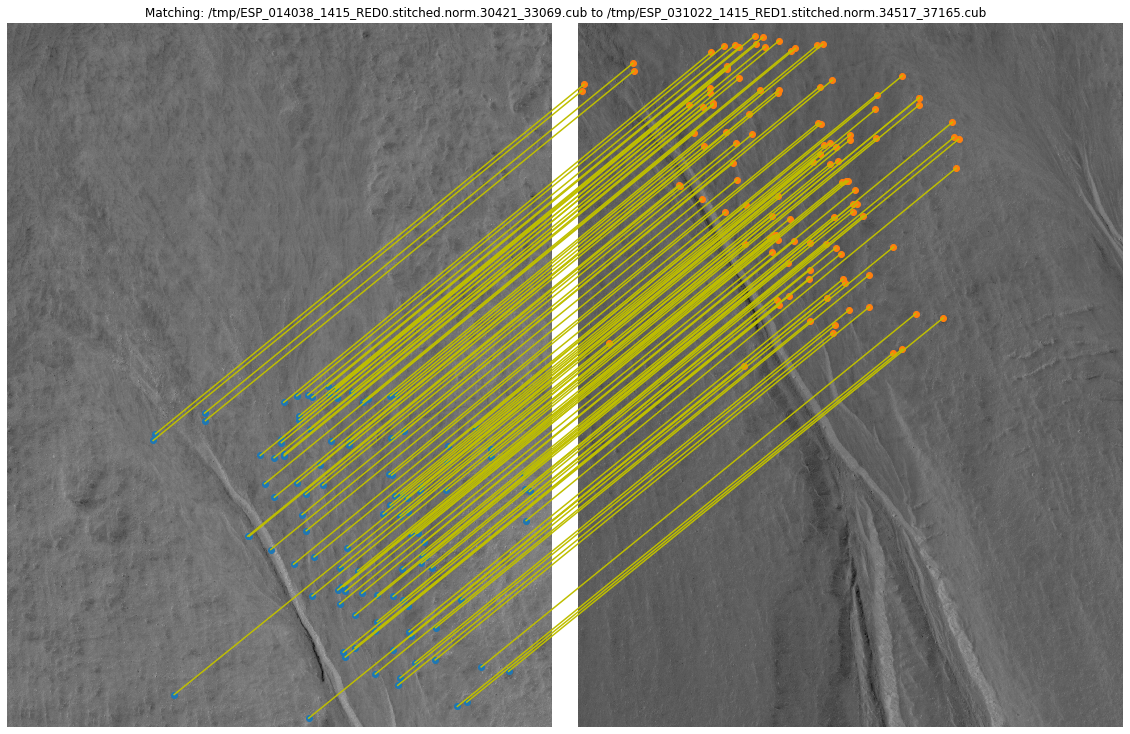

In [64]:
plt.figure(figsize=(20,20))
cg[1][2]["data"].plot(clean_keys=["fundamental"])

In [65]:
cg.generate_control_network(clean_keys=["fundamental"])
cg.to_isis("test.net")

In [68]:
cat test.lis

/tmp/ESP_031022_1415_RED1.stitched.norm.34517_37165.cub
/tmp/ESP_014038_1415_RED0.stitched.norm.30421_33069.cub


In [69]:
try:
    output = isis.jigsaw(fromlist='test.lis', cnet='test.net', onet='bundle_test.cnet', update='yes', radius='yes', errorpropagation='yes', outlier_rejection='yes', point_longitude_sigma=10, point_latitude_sigma=10, point_radius_sigma=2, maxits=20, camsolve='VELOCITIES', twist='yes', overexisting='yes', spsolve='NONE')
    print(output.decode())
except ProcessError as e:
    print(e.stderr)


Validating network...
Validation complete!...
starting iteration 1



median deviation: 0.24237

mad: 0.359338

Rejection Limit: 1.72652


Rejected Observations:0 (Rejection Limit:1.72652)

Measures that came back: 0
Iteration: 1 
Sigma0:         0.4617491986 
Observations: 444 
Constrained Parameters:333 
Unknowns: 345 
Degrees of Freedom: 432 
End of Iteration 1 
Elapsed Time:         0.0100000000 
Group = Iteration1
  Sigma0                       = 0.46174919857278
  Observations                 = 444
  Constrained_Point_Parameters = 333
  Constrained_Image_Parameters = 0
  Unknown_Parameters           = 345
  Degrees_of_Freedom           = 432
  Rejected_Measures            = 0
End_Group
starting iteration 2



median deviation: 0.215381

mad: 0.319323

Rejection Limit: 1.55294


Rejected Observations:0 (Rejection Limit:1.55294)

Measures that came back: 0
Iteration: 2 
Sigma0:         0.4233562023 
Observations: 444 
Constrained Parameters:333 
Unknowns: 345 
Degrees of Freedom: 

In [70]:
roi1_proj = os.path.splitext(roi1.path)[0] + ".proj.cub"
roi2_proj = os.path.splitext(roi2.path)[0] + ".proj.cub"

try:
    isis.cam2map(from_=roi1.path, to=roi1_proj, map='/usgs/cpkgs/isis3/data/base/templates/maps/equirectangular.map')
    isis.cam2map(from_=roi2.path, to=roi2_proj, patchsize=8, map=roi1_proj, matchmap=True, warpalgorithm="REVERSEPATCH")
except ProcessError as e:
    print(e.stderr)

(2913, 2278) (2913, 2278)


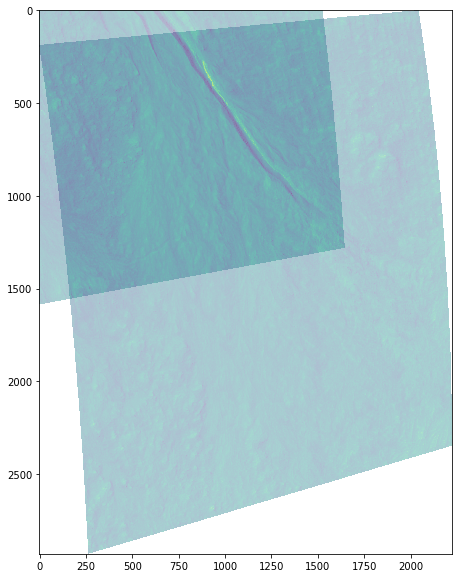

In [71]:
import pysis
roi1_proj_geo = GeoDataset(roi1_proj)
roi2_proj_geo = GeoDataset(roi2_proj)
isis_null = pysis.specialpixels.SPECIAL_PIXELS['Real']['Null']
print(proj_array1.shape, proj_array2.shape)
proj_array1 = roi1_proj_geo.read_array()
proj_array2 = roi2_proj_geo.read_array()

proj_array1[proj_array1 == isis_null] = np.nan
proj_array2[proj_array2 == isis_null] = np.nan

plt.figure(0, figsize=(10, 10))
plt.imshow(proj_array1, alpha=.4)
plt.imshow(proj_array2, alpha=.4)


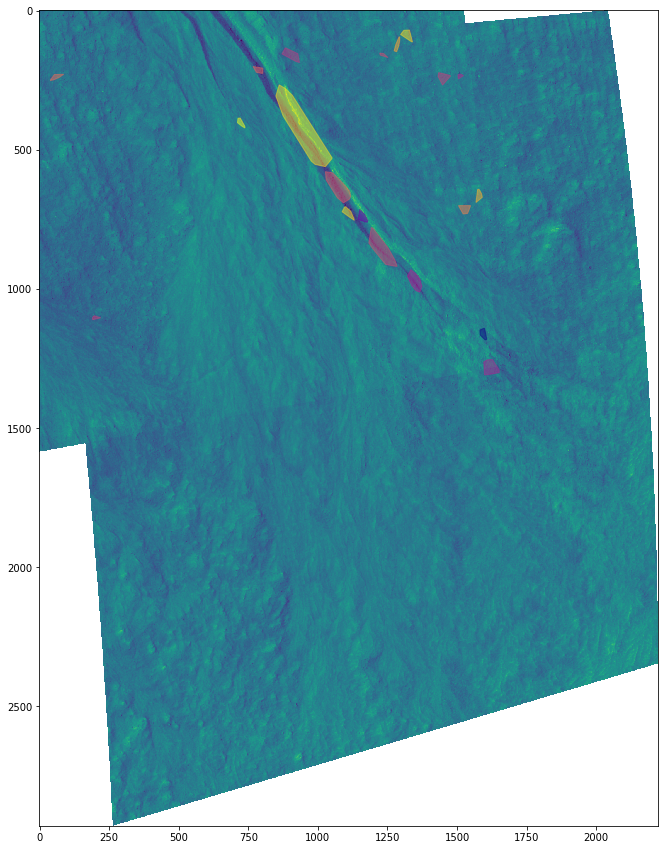

In [72]:
import matplotlib

plt.figure(figsize=(15,15))
cmap = matplotlib.cm.get_cmap('plasma')
colors = bytescale(np.asarray(weights))

plt.imshow(proj_array1)
plt.imshow(proj_array2)

[plt.fill(*p.exterior.xy, c=cmap(colors[i]), alpha=.5) for i,p in enumerate(polys)]

plt.show()